<a href="https://colab.research.google.com/github/javier-jaime/Stock_Price_Forecasting/blob/main/Update4_BTC_Price_Forecasting_with_yfinance_and_Facebook_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bitcoin Price Forecasting with yfinance and Facebook Prophet**

## Importing all the necessary Libraries

In [1]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
from fbprophet import Prophet
import plotly.io as pio
pio.renderers.default='colab'

     |████████████████████████████████| 6.3 MB 28.8 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=4f96f9d7303c1c3c25fb982e56a42991524789ce13862975a1447ad861376d35
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


## Importing the Dataset & Exploring it

In [35]:
# Stock Ticker Input
stock = input('Enter the stock ticker: ')
print(f'You entered {stock}, here is the data from the last 10 days:')
period = '3y'
ticker = yf.Ticker(stock)
data = ticker.history(period)
data.reset_index(inplace=True)
data.tail(10)

Enter the stock ticker: BTC-USD
You entered BTC-USD, here is the data from the last 10 days:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
1083,2021-10-31,61850.488281,62406.171875,60074.328125,61318.957031,32241199927,0,0
1084,2021-11-01,61320.449219,62419.003906,59695.183594,61004.406250,36150572843,0,0
1085,2021-11-02,60963.253906,64242.792969,60673.054688,63226.402344,37746665647,0,0
1086,2021-11-03,63254.335938,63516.937500,61184.238281,62970.046875,36124731509,0,0
1087,2021-11-04,62941.804688,63123.289062,60799.664062,61452.230469,32615846901,0,0
1088,2021-11-05,61460.078125,62541.468750,60844.609375,61125.675781,30605102446,0,0
1089,2021-11-06,61068.875000,61590.683594,60163.781250,61527.480469,29094934221,0,0
1090,2021-11-07,61554.921875,63326.988281,61432.488281,63326.988281,24726754302,0,0
1091,2021-11-08,63344.066406,67673.742188,63344.066406,67566.828125,41125608330,0,0
1092,2021-11-09,67380.914062,68530.335938,66469.273438,66606.140625,43693518848,0,0


In [36]:
print('These are the basic stats:')
data.describe()

These are the basic stats:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1093.000000,1093.000000,1093.000000,1093.000000,1.093000e+03,1093.0,1093.0
mean,19606.338988,20151.456761,19035.588492,19660.083551,3.063507e+10,0.0,0.0
std,18069.724143,18612.164127,17487.103838,18120.967953,2.121805e+10,0.0,0.0
min,3236.274658,3275.377930,3191.303467,3236.761719,3.551764e+09,0.0,0.0
25%,7550.482910,7743.431641,7446.988770,7556.237793,1.708204e+10,0.0,0.0
50%,10126.299805,10279.366211,9831.462891,10131.516602,2.650126e+10,0.0,0.0
75%,33889.605469,34997.664062,32385.214844,33897.046875,3.983784e+10,0.0,0.0
max,67380.914062,68530.335938,66469.273438,67566.828125,3.509679e+11,0.0,0.0


# Data Visualization (plotly express) - Visualizing the historical performance

In [37]:
#Line graph (Price), Area graph (Volume) , box plot (Analyzing price and volume)

In [38]:
px.line(data, x="Date", y="Close", title=f'{stock} Stock Close Price')

In [39]:
px.bar(data, x="Date", y="Volume", title=f'{stock} Stock Volume')

In [40]:
px.box(data, y="Close", title=f'{stock} box plot', height=500, width=500)

In [41]:
def get_hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [42]:
hurst = []
lags = range(8, 81, 4)
for lag in lags:
    hurst_exp = get_hurst_exponent(data["Close"].values, lag)
    hurst.append(hurst_exp)
px.line(hurst, x=lags, y=hurst, title=f'{stock} Hurst Exp')

## Data Preparation for Facebook Prophet

In [43]:
columns=['Date','Close']
prophet_df=pd.DataFrame(data,columns=columns)
prophet_df= prophet_df.rename(columns={'Date':'ds','Close':'y'})  
prophet_df.tail()

,ds,y
1088,2021-11-05,61125.675781
1089,2021-11-06,61527.480469
1090,2021-11-07,63326.988281
1091,2021-11-08,67566.828125
1092,2021-11-09,66606.140625


## Creating Facebook Prophet Model

In [44]:
m=Prophet(daily_seasonality=True)
m.fit(prophet_df)

##Forecasting

In [45]:
periods = 30
future=m.make_future_dataframe(periods)

In [46]:
forecast=m.predict(future)

In [47]:
forecast.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-11-09,5962.594299,2150.480042,9485.436418,5962.594299,5962.594299,-109.516540,-109.516540,-109.516540,-517.415131,-517.415131,-517.415131,71.816981,71.816981,71.816981,336.081610,336.081610,336.081610,0.0,0.0,0.0,5853.077759
1,2018-11-10,5834.794245,2115.576448,9369.308224,5834.794245,5834.794245,-121.366882,-121.366882,-121.366882,-517.415131,-517.415131,-517.415131,35.640432,35.640432,35.640432,360.407817,360.407817,360.407817,0.0,0.0,0.0,5713.427362
2,2018-11-11,5706.994190,2330.716351,9122.432980,5706.994190,5706.994190,-135.089226,-135.089226,-135.089226,-517.415131,-517.415131,-517.415131,-8.932597,-8.932597,-8.932597,391.258502,391.258502,391.258502,0.0,0.0,0.0,5571.904964
3,2018-11-12,5579.194136,1668.106486,8923.486041,5579.194136,5579.194136,-58.034653,-58.034653,-58.034653,-517.415131,-517.415131,-517.415131,30.715384,30.715384,30.715384,428.665094,428.665094,428.665094,0.0,0.0,0.0,5521.159482
4,2018-11-13,5451.394081,1604.189325,8784.183257,5451.394081,5451.394081,-92.999461,-92.999461,-92.999461,-517.415131,-517.415131,-517.415131,-47.891375,-47.891375,-47.891375,472.307045,472.307045,472.307045,0.0,0.0,0.0,5358.394620
5,2018-11-14,5323.594027,1975.353035,8886.252800,5323.594027,5323.594027,6.062000,6.062000,6.062000,-517.415131,-517.415131,-517.415131,1.945232,1.945232,1.945232,521.531899,521.531899,521.531899,0.0,0.0,0.0,5329.656027
6,2018-11-15,5195.793972,1352.492856,8749.646222,5195.793972,5195.793972,-25.324017,-25.324017,-25.324017,-517.415131,-517.415131,-517.415131,-83.294058,-83.294058,-83.294058,575.385172,575.385172,575.385172,0.0,0.0,0.0,5170.469955
7,2018-11-16,5067.993918,1710.850460,8722.940791,5067.993918,5067.993918,187.051104,187.051104,187.051104,-517.415131,-517.415131,-517.415131,71.816981,71.816981,71.816981,632.649255,632.649255,632.649255,0.0,0.0,0.0,5255.045022
8,2018-11-17,4940.193863,1533.470514,8662.173556,4940.193863,4940.193863,210.115608,210.115608,210.115608,-517.415131,-517.415131,-517.415131,35.640432,35.640432,35.640432,691.890307,691.890307,691.890307,0.0,0.0,0.0,5150.309471
9,2018-11-18,4812.393809,1738.908956,8718.483869,4812.393809,4812.393809,225.164169,225.164169,225.164169,-517.415131,-517.415131,-517.415131,-8.932597,-8.932597,-8.932597,751.511897,751.511897,751.511897,0.0,0.0,0.0,5037.557978


In [48]:
px.line(forecast, x='ds',y='yhat', title=f'{stock} Stock Forecast')

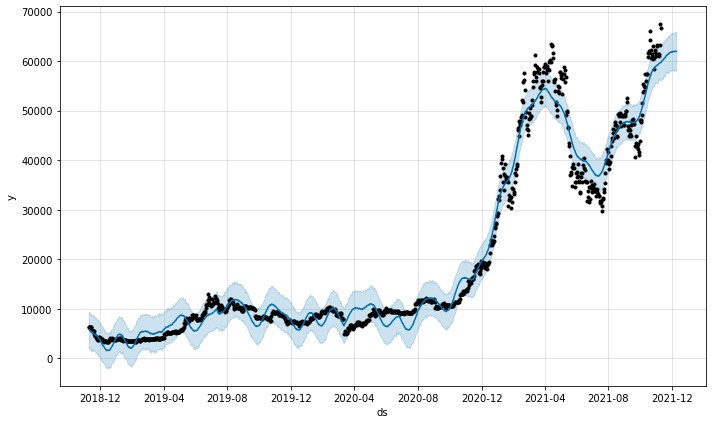

In [49]:
figure=m.plot(forecast, xlabel='ds', ylabel='y')

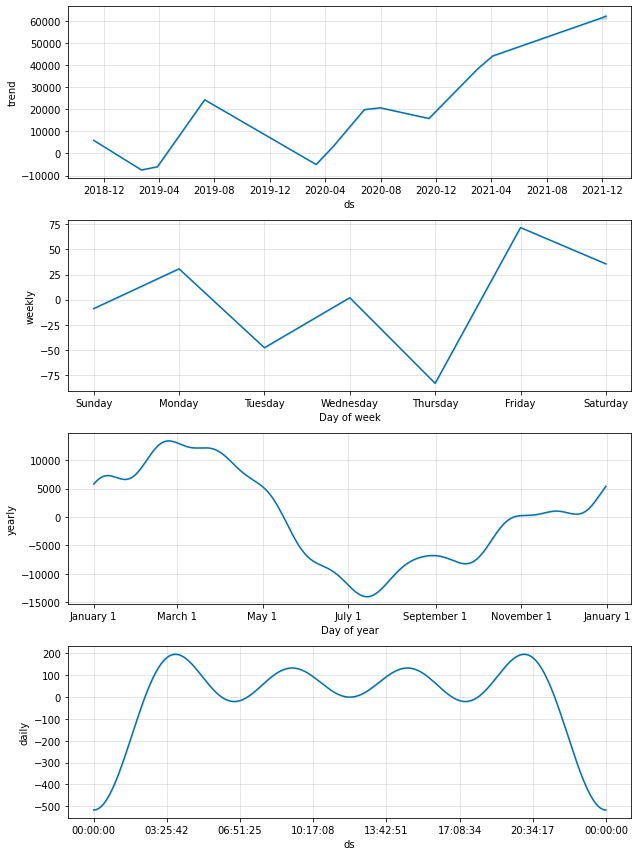

In [50]:
figure2=m.plot_components(forecast)

##Downloading the Forecast data

In [18]:
from google.colab import files
forecast.to_csv(f'{stock}_forecast.csv')
files.download(f'{stock}_forecast.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>